### Particle Swarm Optimization

In [0]:
!pip install pyclipper
#!pip install bamboolib

     |████████████████████████████████| 133kB 2.8MB/s 


In [0]:
# PSO for maximin=zing plot fit

#! / Usr / bin / python
# - * - coding: Latin-1 - * -
# TP optim: surface maximization
# by the PSO algorithm
# Peio Loubiere for EISTI
# September 2017
#use: python surface.corr1.py
from scipy import *
from math import *
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import sys
import pyclipper
from functools import *
import numpy as np
import pandas as pd

# Visualization of the plot
#fig = plt.figure(figsize=(10,10))
#canv = fig.add_subplot(1,1,1)
#canv.set_xlim(0,500)
#canv.set_ylim(0,500)



# ***************** Paramètres du problème ******************
# Différent types of plots : 
#polygon = ((10,10),(10,400),(400,400),(400,10)) 
#polygon = ((10,10),(10,300),(250,300),(350,130),(200,10)) 
#polygon = ((50,150),(200,50),(350,150),(350,300),(250,300),(200,250),(150,350),(100,250),(100,200))
polygon = ((50,50),(50,400),(220,310),(220,170),(330,170),(330,480),(450,480),(450,50))

# ***********************************************************

# Transforms the polygon into a list for display.
def poly2list(polygon):
	polygonfig = list(polygon)
	polygonfig.append(polygonfig[0])
	return polygonfig

# Draw Constant polygon 
polygonfig = poly2list(polygon)

# Display visualization
def draw(polyfig,rectfig):
	global canv, codes
	canv.clear()
	canv.set_xlim(0,500)
	canv.set_ylim(0,500)
	# polygon figure
	codes = [Path.MOVETO]
	for i in range(len(polyfig)-2):
	  codes.append(Path.LINETO)   
	codes.append(Path.CLOSEPOLY)
	path = Path(polyfig, codes)
	patch = patches.PathPatch(path, facecolor='orange', lw=2)
	canv.add_patch(patch)

	# rectangle figure
	codes = [Path.MOVETO]
	for i in range(len(rectfig)-2):
		codes.append(Path.LINETO)
	codes.append(Path.CLOSEPOLY)
	path = Path(rectfig, codes)
	patch = patches.PathPatch(path, facecolor='grey', lw=2)
	canv.add_patch(patch)

	# Title(Area of Rectangle)
	plt.title("Max Area of my House: {}".format(round(area(rectfig[:-1]),2)))
	#plt.savefig('H:\plot'+str(runs)+'.png')
	#plt.clf()
	plt.pause(0.5)

def dispRes(best):
	print("Point = {}".format(best['pos']))
	print("rectangle coordinate = {}".format(pos2rect(best['pos'])))
	print("Best Area = {}".format(best['area']))	
	
def drawStats(Htemps, Hbest):
	# afFILEhage des courbes d'evolution
	fig = plt.figure(2,figsize=(10,10))
	#add_subplot(1,1,1)
	plt.semilogy(Htemps, Hbest)
	plt.title('Evolution of the best distance')
	plt.xlabel('Time')
	plt.ylabel('Area')

	#legend(mains, title='Optimization functions')
	#plt.tight_layout()
	#plt.show()
	#plt.savefig('H:/Desktop/land.png')
	
	
# Collect the boundaries of the bounding box around the parcel
def getbounds(polygon):
	lpoly = list(polygon) #tansformation into list for use with reduce function
	#return reduce(lambda (xmin,xmax,ymin,ymax),(xe,ye): (min(xe,xmin),max(xe,xmax),min(ye,ymin),max(ye,ymax)),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))
	return reduce(lambda acc,e: (min(e[0],acc[0]),max(e[0],acc[1]),min(e[1],acc[2]),max(e[1],acc[3])),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))

# Transformation of a solution of the pb (center / corner / angle) in rectangle for clipping
# Returns a rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
def pos2rect(pos):
	# coin : point A
	xa, ya = pos[0], pos[1]
	# centre du rectangle : point O
	xo, yo = pos[2], pos[3]
	# angle  AÔD
	angle = pos[4]

	# point D : centre for rotation O, at the Angle alpha
	alpha = pi * angle / 180 # degre en radian
	xd = cos(alpha)*(xa-xo) - sin(alpha)*(ya-yo) + xo 
	yd = sin(alpha)*(xa-xo) + cos(alpha)*(ya-yo) + yo
	# point C : symétrique de A, de centre O
	xc, yc = 2*xo - xa, 2*yo - ya 
	# point B : symétrique de D, de centre O
	xb, yb = 2*xo - xd, 2*yo - yd

	# round for clipping
	return ((round(xa),round(ya)),(round(xb),round(yb)),(round(xc),round(yc)),(round(xd),round(yd)))

	
# Distance between 2 points (x1,y1), (x2,y2)
def distance(p1,p2):
	return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# Area of Rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
# = distance AB * distance BC
def area(pos):
	edge1=(pos[0],pos[1])
	edge2=(pos[1],pos[2])
	#print(pos[0],pos[1],pos[2],pos[3])
	#print(distance(p1[0],p1[1])* distance(p2[0],p2[1]))
	return round(distance(edge1[0],edge1[1])* distance(edge2[0],edge2[1]),2)


# Clipping
# Predicate that verifies that the rectangle is in the polygon
# Test if
# - there is an intersection (! = []) between the figures and
# - the two lists are the same size and
# - all the points of the rectangle belong to the result of the clipping
# If error (~ flat angle), returns false

def verifyconstraint(rect, polygon):
	try:
		# Config
		pc = pyclipper.Pyclipper()
		pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
		pc.AddPath(rect, pyclipper.PT_CLIP, True)
		# Clipping
		clip = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
		#all(iterable) return True if all elements of the iterable are true (or if the iterable is empty)		
		return (clip!=[]) and (len(clip[0])==len(rect)) and all(list(map(lambda e:list(e) in clip[0], rect)))
	except pyclipper.ClipperException:
		# print rect
		return False


# Create an individual (center / corner / angle) FEASABLE
# an individual is described by your metaheuristic containing at least:
# - pos: solution (center / corner / angle) list of variables
# - area: area of ​​the rectangle
# - ...: other components of the individual

def initUn(polygon):
	global xmin,xmax,ymin,ymax
	# xmin = 0
	# xmax = 500
	# ymin = 0
	# ymax = 500
	anglemin = 1.00
	anglemax = 90.00
	boolOK = False
	pos = []
	while not boolOK: # as long as it is not feasible
		xo=random.uniform(xmin,xmax)
		yo=random.uniform(ymin,ymax)
		
		xa=xo+pow(-1,random.randint(0,1))*random.uniform(10,min(xo-xmin,xmax-xo))
		ya=yo+pow(-1,random.randint(0,1))*random.uniform(10,min(yo-ymin,ymax-yo))
		angle = random.uniform(anglemin,anglemax)

		pos = [round(xa),round(ya),round(xo),round(yo),angle]
		rect = pos2rect(pos)
		#print(rect)
		# calcul du clipping
		boolOK = verifyconstraint(rect,polygon)
	ev = round(area(pos2rect(pos)),2)
	return {'vit':[0]*dim, 'pos':pos, 'area':ev ,'bestpos':pos, 'bestarea':ev, 'bestvois':[]}

# Initialization of the population
def initPop(nb,polygon):
	return [initUn(polygon) for i in range(nb)]

# Returns the best particle between two: depends on the metaheuristic
def bestPartic(p1,p2):
	#print('comparison')
	#print('------------------------')
	#print(p1)
	#print('------------------------')
	#breakpoint()
	if (p1["area"] < p2["area"]):
		return p2 
	else:
		return p1
	
# Return a copy of the best particle of the population
def getBest(population):
	#print(dict(reduce(lambda acc, e: bestPartic(acc,e),population[1:],population[0])))
	return dict(reduce(lambda acc, e: bestPartic(acc,e),population[1:],population[0]))


#"""
#PSO ALGORITH IMPLEMENTATION
#"""
		

# Initialization of the population (swarm)
def initSwarm(nb,polygon):
	return [initUn(polygon) for i in range(nb)]


# # Return the particle with the best fitness
# def maxParticle(p1, p2):
	# if (p1["area"] < p2["area"]):
		# return p1
	# else:
		# return p2

# Calculate the velocity and move a paticule
def move(particle,dim):
	global c1,c2,psi,cmax

	nv = dict(particle)
	#everytime a new dictionary is created for the single particle of swarm
	#print('--------------------******************-----------')
	#print(nv)
	#break;
	#velocity for 5 parameters
	velocity = [0]*dim
	for i in range(dim):
		velocity[i] = (particle["vit"][i]*psi + \
		cmax*random.uniform()*(particle["bestpos"][i] - particle["pos"][i]) + \
		cmax*random.uniform()*(particle["bestvois"][i] - particle["pos"][i]))
	position = [0]*dim
	for i in range(dim):
		position[i] = particle["pos"][i] + velocity[i]
		#if i==4:
			#position[i] = round(particle["pos"][i] + velocity[i])
	# New position might contradict my dimension constraint
	# i need to verify that cordinates and angle give me a rectangle 
	# which lies in the polgon plot of land
	#print("the angle is ")
	#print(position[4])
	if (position[4] <1.00 or position[4]>90.00):
		position[4] = particle["pos"][4]
		#move(particle,dim)
	if (verifyconstraint(pos2rect(position),polygon) == False): 
		position = particle["pos"]
	#breakpoint()
	nv['vit'] = velocity
	nv['pos'] = position
	nv['area'] = round(area(pos2rect(position)),2)
	return nv		
		
# Update information for the particles of the population (swarm)
def update(particle,bestParticle):
	nv = dict(particle)
	#print('--******************************************---')
	#print(particle["area"])
	#print(particle["bestarea"])
	#print(nv)
	#print('--******************************************---')
	#breakpoint()
	if(particle["area"] > particle["bestarea"]):
		nv['bestpos'] = particle["pos"][:]
		nv['bestarea'] = particle["area"]
	nv['bestvois'] = bestParticle["bestpos"][:]
	#print(nv)
	#breakpoint()
	return nv		
		
		
		
		


# ************ Parameters of the metaheuristic *** PSO = 10000 DE = 1500 ********* NB indiv 20 *
Nb_cycles = 10000
Nb_Indiv = 20
psi, cmax = (0.4, 1.41)
# ***********************************************************
global DIM,dim
DIM = 5
dim = 5
# usual params



# xmin,xmax,ymin,ymax = getbounds(polygon)
# #print(xmin,xmax,ymin,ymax)

# # initialisation of the population (of the agent if simulated annealing) and the best individual.
# swarm = initPop(Nb_Indiv,polygon)
# print('initial swarm')
# #print(swarm)
# #breakpoint()
# best = getBest(swarm)
# #print(best)
# print('------best out of swarm--------')
# best_plot = best
# print(best_plot)
# #breakpoint()
# # -------- Code is working fine till here --------------


final1 = pd.DataFrame()
areali = []
coordli = []

Nb_runs = 30
best_areas = []
best_rectangles = []
for runs in range(Nb_runs):
# --------------------------------------------------
	Htemps = []       # temps
	Hbest = []
	xmin,xmax,ymin,ymax = getbounds(polygon)
	#print(xmin,xmax,ymin,ymax)

	# initialisation of the population (of the agent if simulated annealing) and the best individual.
	swarm = initPop(Nb_Indiv,polygon)
	#print('initial swarm')
	#print(swarm)
	#breakpoint()
	best = getBest(swarm)
	#print(best)
	#print('------best out of swarm--------')
	best_plot = best
	#print(best_plot)
#breakpoint()
# -------- Code is working fine till here --------------
#---------------------------------------------------

	#print("Run no. {}".format(runs))
	for i in range(Nb_cycles):
		#Update informations
		#print("  Current Cycle is  {}".format(i))
		swarm = [update(e,best_plot) for e in swarm]
		#print('iterative swarm')
		#print(swarm)
		#breakpoint()
		# velocity calculations and displacement
		swarm = [move(e,DIM) for e in swarm]
		# Update of the best solution
		#print('printing all the swarms')
		#print(swarm)
		best_plot = getBest(swarm)
		#print("---------------best_plot VS best--------------------")
		#print("{}  V/S {}".format(best_plot['area']).format(best['area']))
		#print(best)
		#print('printing the best plot')
		#print(best_plot)


		if (best_plot["area"] > best["area"]):
			best = best_plot
			# draw(best['pos'], best['fit'])
		#print("---------------And the best is --------------------")
		#print(best['area'])
		coordli.append(best['pos'])
		areali.append(best['area'])
		#breakpoint()
		# historization of data
		if i % 10 == 0:
			Htemps.append(i)
			Hbest.append(best['area'])

		# # swarm display
		# if i % 10 == 0:
			# draw(swarm,i)

	# END, displaying results
	Htemps.append(i)
	Hbest.append(best['area'])

	#dispRes(best)
 
	#print(pos2rect(best["pos"]))
	#print(area(pos2rect(best["pos"])))
	best_areas.append(best['area'])
	best_rectangles.append(pos2rect(best['pos']))
	#draw(polygonfig, poly2list(pos2rect(best["pos"])))
	#plt.show()
	#fig.clf()
	#plt.close()
	#displaying result on the console
	#drawStats(Htemps, Hbest)	
	#"""
	#END OF PSO ALGORITHM
	#"""
	#for i in range(Nb_cycles):
	#	print("the best area at the {} iteration with the coordinates {} is  {}.m^2 " .format(i,coordli[i],areali[i]))
	

final1['Best Coordinate']= best_rectangles
final1['Best Area']= best_areas

In [0]:
final1
top_PSO =  final1[final1['Best Area'] == (max(final1['Best Area']))]
tops_PSO = top_PSO['Best Coordinate'].iloc[0]
tops_PSOa = top_PSO['Best Area'].iloc[0]
tops_PSOa

51601.93

In [0]:
PSO_accuracy = [round(((e*100)/tops_PSOa),1) for e in best_areas]
print(PSO_accuracy)

[85.7, 78.6, 100.0, 83.2, 100.0, 84.8, 100.0, 85.2, 67.2, 81.7, 74.3, 85.5, 69.5, 100.0, 93.0, 99.2, 90.7, 100.0, 84.6, 100.0, 85.3, 81.0, 81.8, 76.7, 85.7, 73.5, 100.0, 77.0, 85.3, 100.0]


### Tabu Search

In [0]:
# -*- coding: Latin-1 -*-
# program that solves the traveling salesman problem (TSP)
# by the taboo search algorithm
# Dominique Lefebvre for TangenteX.com
# Peio Loubiere & Rachid Chelouah for EISTI
# September 2017
from scipy import *
from math import *
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import sys
import pyclipper
from functools import *
import numpy as np
import random
import pandas as pd
# Instance of the problem

# Visualization of the plot
#fig1 = plt.figure(1,figsize=(10,10))
#canv = fig1.add_subplot(1,1,1)
#canv.set_xlim(0,500)
#canv.set_ylim(0,500)

# ***************** Paramètres du problème ******************
# Différent types of plots : 
#polygon = ((10,10),(10,400),(400,400),(400,10)) 
#polygon = ((10,10),(10,300),(250,300),(350,130),(200,10)) 
#polygon = ((50,150),(200,50),(350,150),(350,300),(250,300),(200,250),(150,350),(100,250),(100,200))
polygon = ((50,50),(50,400),(220,310),(220,170),(330,170),(330,480),(450,480),(450,50))

# ***********************************************************

# Transforms the polygon into a list for display.
def poly2list(polygon):
	polygonfig = list(polygon)
	polygonfig.append(polygonfig[0])
	return polygonfig

# Draw Constant polygon 
polygonfig = poly2list(polygon)

# Display visualization
def draw(polyfig,rectfig):
	global canv, codes
	canv.clear()
	canv.set_xlim(0,500)
	canv.set_ylim(0,500)
	# polygon figure
	codes = [Path.MOVETO]
	for i in range(len(polyfig)-2):
	  codes.append(Path.LINETO)   
	codes.append(Path.CLOSEPOLY)
	path = Path(polyfig, codes)
	patch = patches.PathPatch(path, facecolor='orange', lw=2)
	canv.add_patch(patch)

	# rectangle figure
	codes = [Path.MOVETO]
	for i in range(len(rectfig)-2):
	  codes.append(Path.LINETO)   
	codes.append(Path.CLOSEPOLY)
	path = Path(rectfig, codes)
	patch = patches.PathPatch(path, facecolor='grey', lw=2)
	canv.add_patch(patch)

	# Title(Area of Rectangle)

	plt.title("Max Area of my House: {}".format(round(area(rectfig[:-1]),2)))
	plt.draw()
	plt.pause(0.1)

# Figure of graphs of:
#   - all the energy of the retained fluctuations 
#   - The best energy
#   - temperature decrease
def drawStats(Htemps, Hbest):
	# afFILEhage des courbes d'evolution
	fig = plt.figure(2,figsize=(10,10))
	#add_subplot(1,1,1)
	plt.semilogy(Htemps, Hbest)
	plt.title('Evolution of the best Area using TA')
	plt.xlabel('Time')
	plt.ylabel('Area')
	#legend(mains, title='Optimization functions')
	#plt.tight_layout()
	plt.show()
	#plt.savefig('H:/Desktop/land1.png')
	
#display the best results
def dispRes(bplot,barea):
	print("coordinates = {}".format(bplot))
	#print("rectangle coordinate = {}".format(pos2rect(best['pos'])))
	print("Best Area = {}".format(barea))	

	
# Collect the boundaries of the bounding box around the parcel
def getbounds(polygon):
	lpoly = list(polygon) #tansformation into list for use with reduce function
	#return reduce(lambda (xmin,xmax,ymin,ymax),(xe,ye): (min(xe,xmin),max(xe,xmax),min(ye,ymin),max(ye,ymax)),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))
	return reduce(lambda acc,e: (min(e[0],acc[0]),max(e[0],acc[1]),min(e[1],acc[2]),max(e[1],acc[3])),lpoly[1:],(lpoly[0][0],lpoly[0][0],lpoly[0][1],lpoly[0][1]))
# ###################################################################################################################################################################################################################################
# Transformation of a solution of the pb (center / corner / angle) in rectangle for clipping
# Returns a rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
def pos2rect(pos):
	# coin : point A
	xa, ya = pos[0], pos[1]
	# centre du rectangle : point O
	xo, yo = pos[2], pos[3]
	# angle  AÔD
	angle = pos[4]

	# point D : centre for rotation O, at the Angle alpha
	alpha = pi * angle / 180 # degre en radian
	xd = cos(alpha)*(xa-xo) - sin(alpha)*(ya-yo) + xo 
	yd = sin(alpha)*(xa-xo) + cos(alpha)*(ya-yo) + yo
	# point C : symétrique de A, de centre O
	xc, yc = 2*xo - xa, 2*yo - ya 
	# point B : symétrique de D, de centre O
	xb, yb = 2*xo - xd, 2*yo - yd

	# round for clipping
	return ((round(xa),round(ya)),(round(xb),round(yb)),(round(xc),round(yc)),(round(xd),round(yd)))

	
# Distance between 2 points (x1,y1), (x2,y2)
def distance(p1,p2):
	return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

# Area of Rectangle (A (x1, y1), B (x2, y2), C (x3, y3), D (x4, y4))
# = distance AB * distance BC
def area(pos):
	edge1=(pos[0],pos[1])
	edge2=(pos[1],pos[2])
	#print(pos[0],pos[1],pos[2],pos[3])
	#print(distance(p1[0],p1[1])* distance(p2[0],p2[1]))
	return round(distance(edge1[0],edge1[1])* distance(edge2[0],edge2[1]),2)
	
#def area ((pa, pb, pc, pd)):
# return distance (pa, pb) * distance (pb, pc)

# Clipping
# Predicate that verifies that the rectangle is in the polygon
# Test if
# - there is an intersection (! = []) between the figures and
# - the two lists are the same size and
# - all the points of the rectangle belong to the result of the clipping
# If error (~ flat angle), returns false

def verifyconstraint(rect, polygon):
	try:
		# Config
		pc = pyclipper.Pyclipper()
		pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
		pc.AddPath(rect, pyclipper.PT_CLIP, True)
		# Clipping
		clip = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
		#all(iterable) return True if all elements of the iterable are true (or if the iterable is empty)		
		return (clip!=[]) and (len(clip[0])==len(rect)) and all(list(map(lambda e:list(e) in clip[0], rect)))
	except pyclipper.ClipperException:
		# print rect
		return False


def initUn(polygon):
	global xmin,xmax,ymin,ymax
	# xmin = 0
	# xmax = 500
	# ymin = 0
	# ymax = 500
	anglemin = 1.00
	anglemax = 89.99
	boolOK = False
	pos = []
	#print(pos)
	while not boolOK: # as long as it is not feasible
		xo=random.uniform(xmin,xmax)
		yo=random.uniform(ymin,ymax)
		
		xa=xo+pow(-1,random.randint(0,1))*random.uniform(10,min(xo-xmin,xmax-xo))
		ya=yo+pow(-1,random.randint(0,1))*random.uniform(10,min(yo-ymin,ymax-yo))
		angle = random.uniform(anglemin,anglemax)

		pos = [round(xa),round(ya),round(xo),round(yo),angle]
		rect = pos2rect(pos)
		#print(rect)
		#print('*************')
		#print(pos)
		#print(area(pos2rect(pos)))
		# calcul du clipping
		boolOK = verifyconstraint(rect,polygon)
	#print(pos2rect(pos))
	#print(rect)
	#print(pos)
	#print(area(pos2rect(pos)))
	ev = area(pos2rect(pos))
	#print(ev)
	return {'pos':pos, 'area':ev}

# for neighbours use initdeux
def initdeux(polygon):
	global xmin,xmax,ymin,ymax
	# xmin = 0
	# xmax = 500
	# ymin = 0
	# ymax = 500
	anglemin = 1.00
	anglemax = 89.99
	boolOK = False
	pos = []
	#print(pos)
	while not boolOK: # as long as it is not feasible
		xo=random.uniform(xmin,xmax)
		yo=random.uniform(ymin,ymax)
		
		xa=xo+pow(-1,random.randint(0,1))*random.uniform(10,min(xo-xmin,xmax-xo))
		ya=yo+pow(-1,random.randint(0,1))*random.uniform(10,min(yo-ymin,ymax-yo))
		angle = random.uniform(anglemin,anglemax)

		pos = [round(xa),round(ya),round(xo),round(yo),angle]
		rect = pos2rect(pos)
		boolOK = verifyconstraint(rect,polygon)

	return {'pos':pos}




def bestNeighbor(nbNeigh, ltaboo):
	global bestV, bestDist
	#list of indices to swap to generate Neighbors
	lperm = [initUn(polygon) for a in range(nbNeigh)]
	#print(' --------------- The neighbours are as follows -----------')
	#print(lperm)
	#print('----------------------------------------------------------')
	#breakpoint()
	# case of the first neighbor
	prem = lperm.pop(0)
	best_neighbor = prem['pos']
	best_n_area = area(pos2rect(prem['pos']))
	#breakpoint()	
	for i in range(nbNeigh-1):
		Neigh = lperm[i]['pos']
		if Neigh not in ltaboo:
				d = area(pos2rect(Neigh))
				if (d > best_n_area):
					best_neighbor = Neigh
					best_n_area = d
	return (best_neighbor,best_n_area)

# #############################################################################################

final = pd.DataFrame()
areali = []
coordli = []

Nb_runs = 30
best_areas = []
best_rectangles = []
for runs in range(Nb_runs):

# ###################################### Parameters of taboo ##################################
  # Parameters of taboo
  ntaboo = 5
  nbNeigh = 40
  iterMax = 10000
  idemMax = iterMax/10

  # initializing history lists
  Htime = []        # time
  Hbest = []        # distance

  ltaboo = []       # taboo list

  # # i need coords
  #coord =  # We build the table of coordinates (x,y)
  xmin,xmax,ymin,ymax = getbounds(polygon)

  # definition of the initial plot: increasing order of cities
  plot = initUn(polygon)
  print('*****')
  # print(plot)
  # print('*****')
  # calculation of the initial Energy of the system (the initial distance to be minimized)
  areas = area(pos2rect(plot['pos']))
  # initialization of the best plot
  best_plot = plot['pos']
  best_area = areas
  #print(" the very first best is {}   {} ".format(best_plot,best_area))
  #breakpoint()



  # ##################################### PRINCIPAL LOOP OF THE ALGORITHM ############################

  i=0
  cptIdem = 0
  # initialization of the taboo list
  ltaboo.insert(0,best_plot)
  #print(ltaboo)
  # main loop of the taboo algorithm
  while i <= iterMax:# and cptIdem <= idemMax:
      # get the best Neighbor
    (Neighbor, areas) = bestNeighbor(nbNeigh, ltaboo)
    #print('Comparison')
    #print(" the very best of all the neighbour is {}   {} ".format(Neighbor,areas))
    #print(Neighbor, areas)
    #print(" Previous best is {}   {} ".format(best_plot,best_area))
    # comparison to the best, if it is better, save it and refresh the figure
    if areas > best_area:
      cptIdem = 0
      best_area = areas
      best_plot = Neighbor
      #draw(best_plot, best_area, x, y)
    #print(" the very best between neighbor and the Previous best is {}   {} ".format(best_plot,best_area))
    #breakpoint() # working breakpoint
    # add to taboo list
    ltaboo.insert(0,Neighbor)
    if (len(ltaboo) > ntaboo):
      ltaboo.pop()

    cptIdem += 1
    #print('My taboo list is /n {}'.format(ltaboo))
    #breakpoint() # working breakpoint
    # next iteration
    i += 1
    plot = Neighbor
    # historization of data
    if i % 10 == 0:
      Htime.append(i)
      Hbest.append(best_area)

  # ##################################### END OF ALGORITHM - DISPLAY RESULTS ############################

  # display of the result in the console
  #dispRes(best_plot, best_area)
  # statistics chart
  best_areas.append(best_area)
  best_rectangles.append(pos2rect(best_plot))


  # # END, displaying results
  # Htemps.append(i)
  # Hbest.append(best['area'])+
  # dispRes(best)
  #print(pos2rect(best["pos"]))
  #print(area(pos2rect(best["pos"])))
  #draw(polygonfig, poly2list(pos2rect(best_plot)))
  #plt.show()		
  #displaying result on the console
  #drawStats(Htime, Hbest)	
  #print(ltaboo)
  # #"""
  # #END OF PSO ALGORITHM
  # #"""
  #for i in range(Nb_cycles):
    #print("the best area at the {} iteration with the coordinates {} is  {}.m^2 " .format(i,coordli[i],areali[i]))

final['Best Coordinate']= best_rectangles
final['Best Area']= best_areas


*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****
*****


In [0]:
final
top_TS =  final[final['Best Area'] == (max(final['Best Area']))]
tops_TS = top_TS['Best Coordinate'].iloc[0]
tops_TSa = top_TS['Best Area'].iloc[0]
tops_TSa

47328.57

In [0]:
TS_accuracy = [round(((e*100)/tops_TSa),1) for e in best_areas]
print(TS_accuracy)

[91.9, 83.7, 90.8, 91.9, 87.8, 85.9, 82.7, 82.8, 91.5, 88.2, 90.8, 100.0, 86.9, 88.9, 94.3, 90.1, 93.0, 89.0, 90.1, 96.4, 90.6, 89.7, 88.2, 88.3, 85.1, 96.4, 95.1, 95.8, 89.7, 84.7]


### **Comparison between PSO V/S TS**

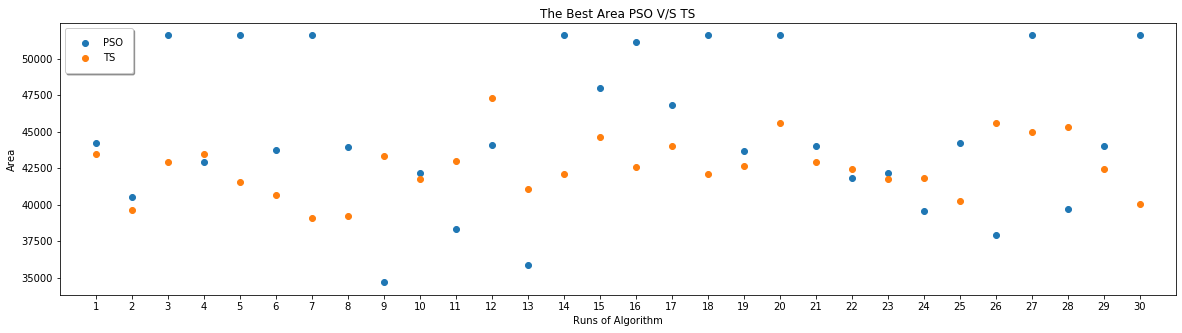

In [0]:
plt.figure(figsize=(20,5))
plt.xlim(0,31)
plt.xticks(np.arange(1,31,1))
plt.title('The Best Area PSO V/S TS')
plt.xlabel('Runs of Algorithm')
plt.ylabel('Area')
plt.scatter(linspace(1,30,num=30), final1['Best Area'],label='PSO')
plt.scatter(linspace(1,30,num=30), final['Best Area'],label='TS')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

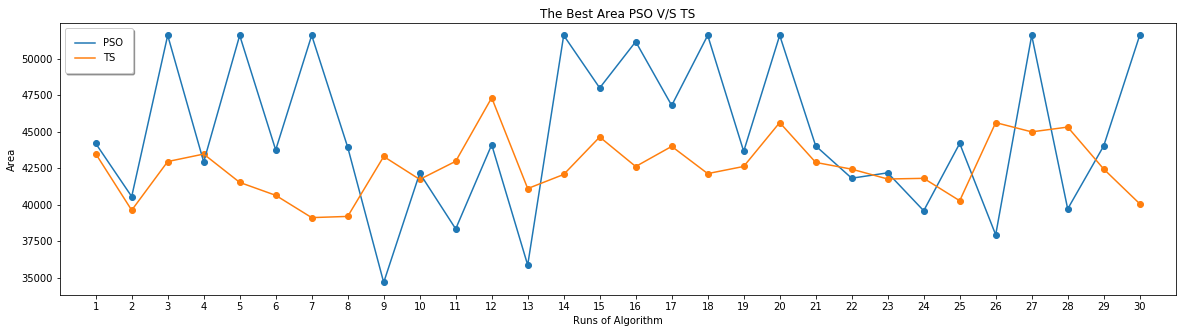

In [0]:
plt.figure(figsize=(20,5))
plt.xlim(0,31)
plt.xticks(np.arange(1,31,1))
plt.title('The Best Area PSO V/S TS')
plt.xlabel('Runs of Algorithm')
plt.ylabel('Area')
plt.scatter(linspace(1,30,num=30), final1['Best Area'])
plt.scatter(linspace(1,30,num=30), final['Best Area'])
plt.plot(linspace(1,30,num=30), final1['Best Area'],label='PSO')
plt.plot(linspace(1,30,num=30), final['Best Area'],label='TS')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

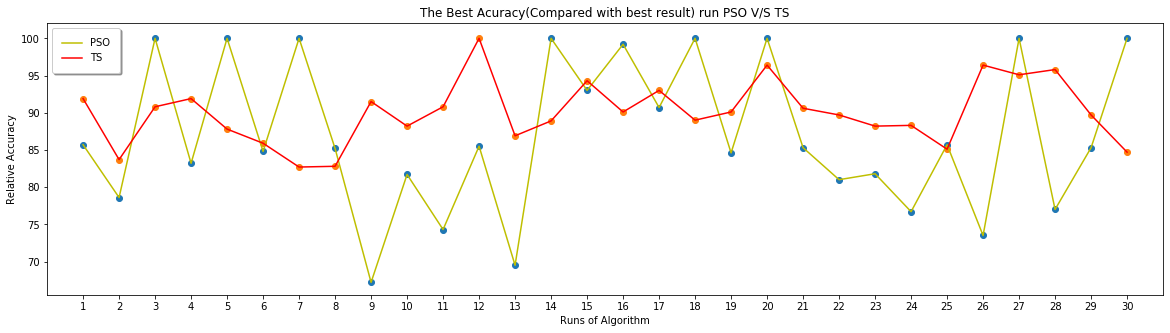

In [0]:
plt.figure(figsize=(20,5))
plt.xlim(0,31)
plt.xticks(np.arange(1,31,1))
plt.title('The Best Acuracy(Compared with best result) run PSO V/S TS')
plt.xlabel('Runs of Algorithm')
plt.ylabel('Relative Accuracy')
plt.scatter(linspace(1,30,num=30), PSO_accuracy)
plt.scatter(linspace(1,30,num=30), TS_accuracy)
plt.plot(linspace(1,30,num=30), PSO_accuracy,'y',label = 'PSO')
plt.plot(linspace(1,30,num=30), TS_accuracy,'r',label = 'TS')
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.show()

In [0]:
deg = pd.DataFrame(data=[PSO_accuracy,TS_accuracy])
deg1=transpose(deg)
deg1.columns=['PSO','Taboo Search']
#lt.boxplot(deg,labels=['PSO', 'Taboo Search'])

Text(0.5, 1.0, 'Relative Accuracy')

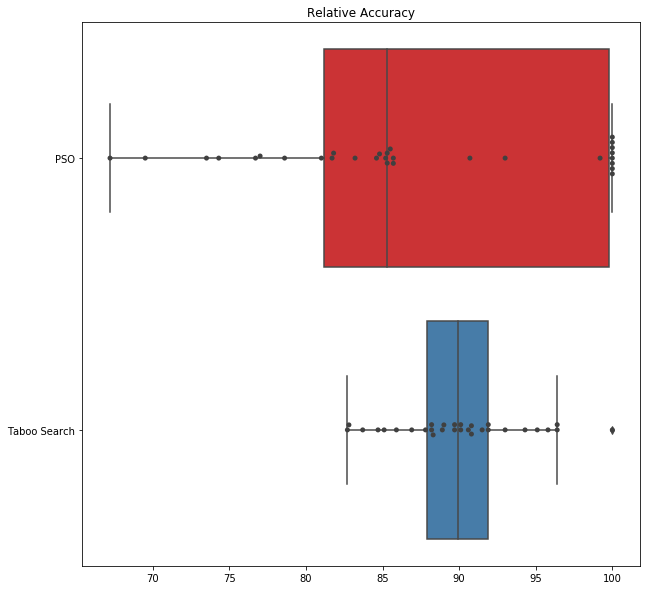

In [0]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.boxplot(data = deg1,orient="h", palette="Set1")
sns.swarmplot(data = deg1,orient="h",color=".25")
plt.title("Relative Accuracy")
#plt.yticks(['PSO', 'Taboo Search'])

Text(0.5, 1.0, 'Comparison Areas')

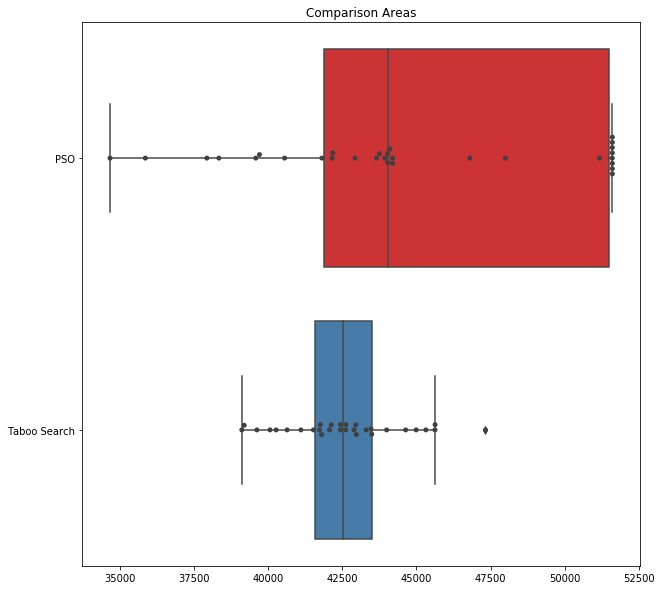

In [0]:
adeg = transpose(pd.DataFrame(data = [final1['Best Area'],final['Best Area']]))
adeg.columns= ['PSO', 'Taboo Search']
#adeg.boxplot()
plt.figure(figsize=(10,10))
sns.boxplot(data = adeg,orient="h", palette="Set1")
sns.swarmplot(data = adeg,orient="h",color=".25")
plt.title("Comparison Areas")

In [0]:
from scipy import stats
np.random.seed(12345678)

In [0]:
rvs1 = stats.norm.rvs(loc=5,scale=10,size=500)
rvs2 = stats.norm.rvs(loc=5,scale=10,size=500)
stats.ttest_ind(rvs1,rvs2)




Ttest_indResult(statistic=0.26833823296238857, pvalue=0.788494433695651)

In [0]:
stats.ttest_ind(final['Best Area'],final1['Best Area'],equal_var=False)

Ttest_indResult(statistic=-2.231564300083014, pvalue=0.03173688537741789)

### **Using t-Test for two different sample of means **

In [0]:
 a = sqrt((var(final1['Best Area']) +  var(final['Best Area']))/30)

In [0]:
b = mean(final1['Best Area']) - mean(final['Best Area'])

In [0]:
#alpha = 95% confidence
Z_alpha = 1.96
if (b/a< Z_alpha):
  print('mean of TABU Search is best')
  print(b/a)
if (b/a> Z_alpha):
  print('mean of PSO is best')  
  print(b/a)
if (b/a == Z_alpha):
  print('mean of the two algorithms is same')  
  print(b/a)

mean of PSO is best
2.269713461804123
